In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *

In [5]:
class espectro:
    
    def __init__(self, canales, cuentas, muestra):
        
        # ponemos todos los datos en arrays y calculamos sus respectivos errores
        
        self.muestra = muestra
        self.cuentas = np.array(cuentas)
        self.canales = np.array(canales)
        self.tiempo = 24.4*np.array(canales) # en pico-segundos (50ns/2048ch)
        
        self.err_cuentas = np.array([0.25 + np.sqrt(abs(N)) for N in self.cuentas])
        self.err_canales = np.array([0.5 for ch in self.canales])
        self.err_tiempo = 24.4*self.err_canales # en pico-segundos
        
    def calibrar(self, sigma):
        
        # buscamos el canal que corresponda al maximo en las cuentas y lo restamos
        # despues le sumamos el sigma de calibracion
        
        MAX_CH = np.argmax(self.cuentas)
        
        self.canales = self.canales - self.canales[MAX_CH] + sigma
        self.tiempo = self.tiempo - self.tiempo[MAX_CH] + sigma

        
    
    def plot(self, log=False):
        
        fig = plt.figure(figsize=(10,6))
        
        plt.plot(self.tiempo, self.cuentas, 'o')
        plt.xlabel('tiempo (ps)', fontsize = 13)
        plt.ylabel('Cuentas', fontsize = 13)
        plt.title("Espectro {}".format(self.muestra))
        plt.legend()
        plt.grid()
        
        if log:
            plt.yscale('log')
            
        return fig
    
    
    def fit(self, func, beta_init, pprint=False, use_err = False):
        
        # funcion general de fiteo con ODR con cualquier modelo con restricciones en que seccion fittear
        
        model = Model(func)
        
        x_fit = self.tiempo
        y_fit = self.cuentas
        
        err_x_fit = self.err_tiempo
        err_y_fit = self.err_cuentas
        
        if use_err:
            data_fit= RealData(x_fit, y_fit,sx=err_x_fit, sy=err_y_fit)
        else:
            data_fit= RealData(x_fit, y_fit)
        
        odr_fit = ODR(data_fit, model, beta0=beta_init)
        out = odr_fit.run()
        params = np.array(out.beta)
        err_params = np.array(out.sd_beta)
        chi_red_dof = out.res_var  # ODR ya usa esto como estimador de chi_red_dof
        
        if pprint:
            out.pprint()
            
            
        return params, err_params, chi_red_dof
    
    
    def estimar_tiempos(self):
        
        # pasamos las cuentas a logaritmo para hacer evidente 
        # cuantos tiempos hay y poder definir una buena funcion de ajuste
        
        log_cuentas = np.log(self.cuentas)
        N_MAX = log_cuentas.size
        
        # las diferencias en log deberian ser constantes en la zona donde
        # domina cada tiempo caracteristico 
        
        diff_log = -1/np.gradient(log_cuentas, self.tiempo)
        
        plt.plot(self.tiempo,diff_log, 'o')
        plt.xlabel("tiempo (ps)")
        plt.ylabel('est_tau')
        plt.ylim(0,2000)
        plt.show()
    
    
    
        

No handles with labels found to put in legend.


Beta: [2932.06381479 5793.63562016  117.88718514]
Beta Std Error: [45.03796308  2.9423353   1.46742152]
Beta Covariance: [[ 1.20910412e+03  1.65602383e+00 -1.11234001e+01]
 [ 1.65602383e+00  5.16048530e+00  1.29572288e-02]
 [-1.11234001e+01  1.29572288e-02  1.28355946e+00]]
Residual Variance: 1.6776207138250898
Inverse Condition #: 0.031317977508412954
Reason(s) for Halting:
  Sum of squares convergence


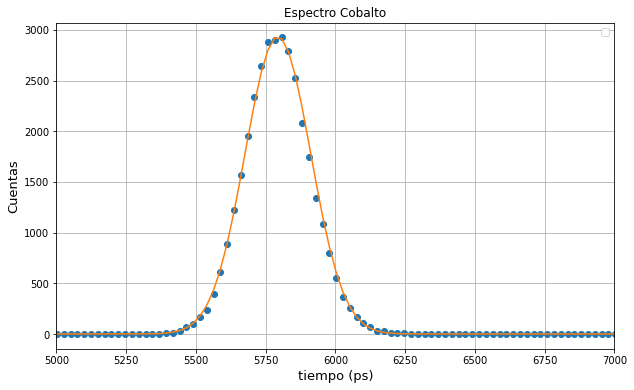

 
 ----------------------------------------  
Resolución:  117.88718514193798 +/- 1.4674215241541282 ps
 ----------------------------------------  
 


In [9]:
file_calib = open("COSET.ASC", "r")

canales_calib = []
cuentas_calib = [] 

for line in file_calib:
    if "," in line:
        ch, cuentas, ROI = [float(x) for x in line.split(", ")]
        
        # EL ROI no lo guardo porque no lo uso en ningun lado
        
        canales_calib.append(ch)
        cuentas_calib.append(cuentas)

file_calib.close()

spec_calib = espectro(canales_calib, cuentas_calib, 'Cobalto')
fig_calib = spec_calib.plot()
plt.xlim(5e3, 7e3)


def gaussian(B,x):
    return B[0]*np.exp((-(x - B[1])**2)/(2*B[2]**2))

beta_init_calib = [3000, 5850, 111]

param_calib, err_param_calib, chi_redof_calib = spec_calib.fit(gaussian, beta_init_calib, pprint=True, use_err = True)

plt.plot(spec_calib.tiempo, gaussian(param_calib, spec_calib.tiempo))
plt.show()

# DEFINIMOS LA RESOLUCION 

RES, ERR_RES =  param_calib[2], err_param_calib[2]

print(" \n ----------------------------------------  ")
print("Resolución: ", RES, "+/-", ERR_RES , "ps")
print(" ----------------------------------------  \n ")

        

No handles with labels found to put in legend.


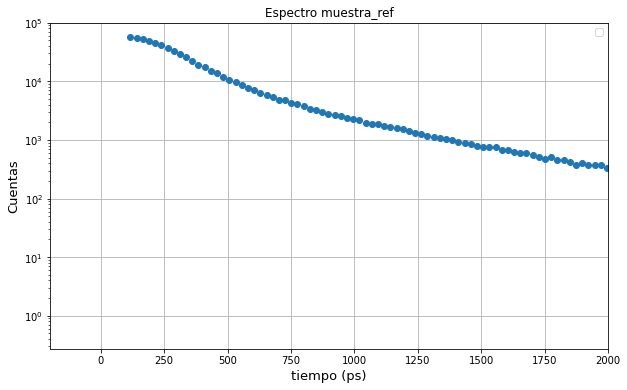

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


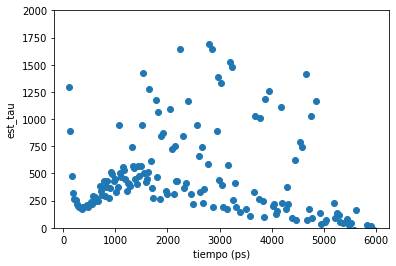

No handles with labels found to put in legend.


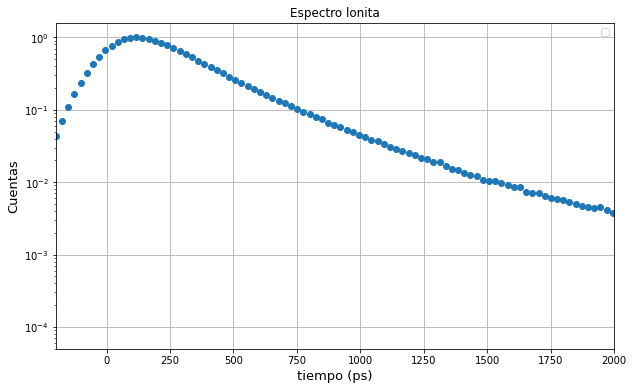

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


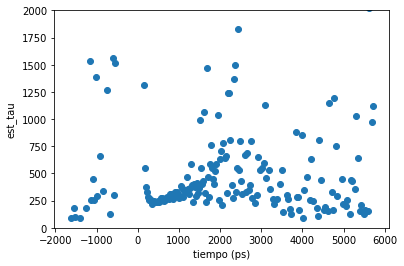

No handles with labels found to put in legend.


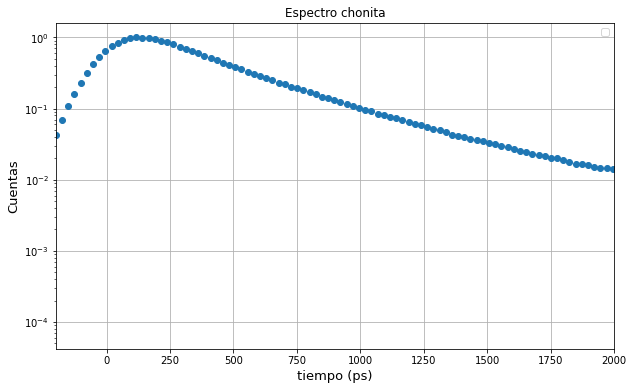

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


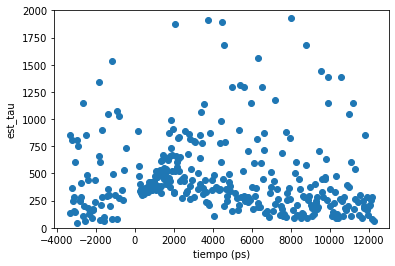

No handles with labels found to put in legend.


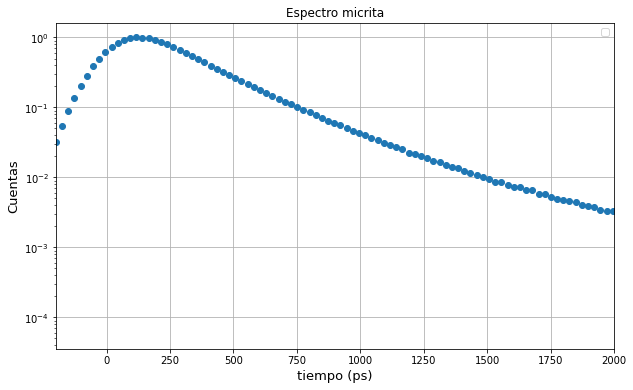

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


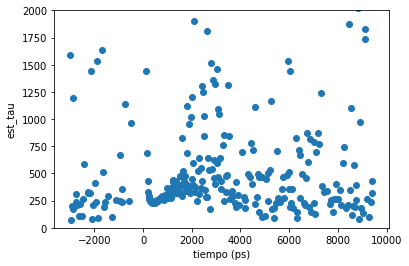

In [7]:
file_names = ['muestra_ref.dat', "lonita.dat", "chonita.dat", "micrita.dat"]

specs = {}

def load_file(file_name):
    
    data_file = open(file_name, "r")
    
    ch = []
    cuentas = []
    
    for line in data_file:
        c, cts = [float(x.replace(",", ".")) for x in line.split("\t")]
        ch.append(c)
        cuentas.append(cts)
        
    data_file.close()
        
    return np.array(ch), np.array(cuentas)


for file_name in file_names:
    
    # para cada muestra armamos un espectro
    
    nombre_muestra = file_name.split(".")[0]
    ch_spec, cuentas_spec = load_file(file_name)
    
    # como ya tenemos al resolución ademas calibramos bien el tiempo
    
    specs[nombre_muestra] = espectro(ch_spec, cuentas_spec, nombre_muestra)
    specs[nombre_muestra].calibrar(RES)
    specs[nombre_muestra].plot(log=True)
    plt.xlim(-200,2e3)
    plt.show()
    specs[nombre_muestra].estimar_tiempos()
  




No handles with labels found to put in legend.


Beta: [   4.31875302  996.76896632  134.69796031  172.32236207  322.80185382
 1460.0328203   126.38785803]
Beta Std Error: [  0.52779542  26.09730273   5.51065241  45.39495493  21.45489432
 191.86695101  13.762737  ]
Beta Covariance: [[ 1.10972165e-01 -5.39696977e+00  1.77761971e-03  7.02910112e+00
  -3.72272674e+00  9.80342663e+00 -1.48428870e+00]
 [-5.39696977e+00  2.71315169e+02 -2.86315853e-01 -3.12192794e+02
   1.67885764e+02 -4.19577712e+02  6.50320637e+01]
 [ 1.77761971e-03 -2.86315853e-01  1.20973116e+01  4.51040429e+00
  -2.35244184e+00  1.49828364e+02 -8.40050694e+00]
 [ 7.02910112e+00 -3.12192794e+02  4.51040429e+00  8.20914653e+02
  -3.82175229e+02  1.93774246e+03 -2.15847241e+02]
 [-3.72272674e+00  1.67885764e+02 -2.35244184e+00 -3.82175229e+02
   1.83373084e+02 -7.99589754e+02  9.51045934e+01]
 [ 9.80342663e+00 -4.19577712e+02  1.49828364e+02  1.93774246e+03
  -7.99589754e+02  1.46650375e+04 -9.16398784e+02]
 [-1.48428870e+00  6.50320637e+01 -8.40050694e+00 -2.15847241e+0

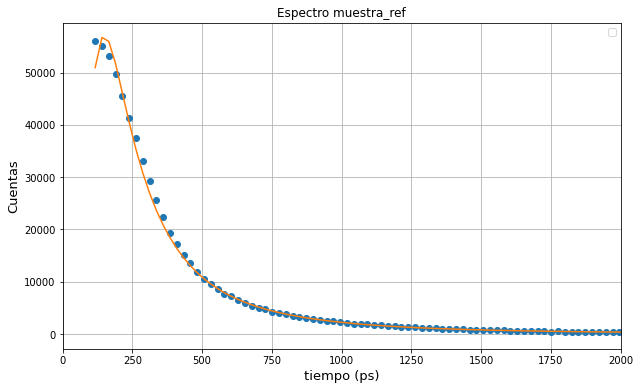

In [11]:
# Ahora usamos la convolucion de guassianas con exponenciales y e intenemos ajustar ese modlo a los espectros
from scipy.special import erf

def conv(B,x):
    
    """ 
    B[0] = amplitud
    B[1] = tau
    B[2] = sigma
    
    """
    
    T1 = (B[0]/2*B[1])*np.exp(((B[2]**2)/B[1] - 2*x)/(2*B[1]))
    T2 = erf(-((B[2]**2)/B[1] - 2*x)/(np.sqrt(2)*B[2]))
    
    return T1*T2


def conv_exp_2(B,x):
    

    p1 = [B[0], B[1], B[2]]
    p2 = [B[2], B[3], B[2]]
    
    f1 = conv(p1,x)
    f2 = conv(p2,x)
    
    return f1 + f2

def conv_exp_3(B,x):
    
 
    p1 = [B[0], B[1], B[2]]
    p2 = [B[3], B[4], B[2]]
    p3 = [B[5], B[6], B[2]]
    
    f1 = conv(p1,x)
    f2 = conv(p2,x)
    f3 = conv(p3,x)

    return f1 + f2 + f3


beta_init = [0.5e3, 1200, 200, 1e3, 400, 1e3, 200]
p, err_p, chi_red = specs['muestra_ref'].fit(func=conv_exp_3, beta_init = beta_init, pprint=True, use_err = True)
fig = specs['muestra_ref'].plot()
plt.plot(specs['muestra_ref'].tiempo, conv_exp_3(p, specs['muestra_ref'].tiempo))

plt.xlim(0,2000)

print("res:", p[2], "+/-", err_p[2], " ps")
print("tau_1:",p[1], "+/-", err_p[1], " ps")
print("tau_2:",p[4], "+/-", err_p[4], " ps")
print("tau_3:",p[6], "+/-", err_p[6], " ps")



    
